In [21]:
import numpy as np
import awkward as ak
np.random.seed(1337)  # for reproducibility

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import gc

import utils as pic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
lr_init     = 1.e-5    # Initial learning rate  
batch_size  = 100       # Training batch size
train_size  = 5000     # Training size
valid_size  = 2500     # Validation size
test_size   = 2500     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU
tmin        = -0.1    # Minimum time cutoff
tmax        = 0.1     # Maximum time cutoff
tstep       = 0.0085   # Time steps

In [35]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(pic.decays)*train_size) % batch_size == 0
X_train, y_train = pic.load_data(train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = pic.load_data(valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = pic.load_data(test_start,test_stop)

samples_requested = len(pic.decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [36]:
pca_dim = 16*16

In [37]:
X_train = X_train[:,:,:,0]
scaler = pic.MinMaxScaler(0.005).fit(X_train)
X_train = scaler.transform(X_train)
pca = PCA(pca_dim).fit(X_train.reshape(-1,32*32))

X_p_train = pca.transform( scaler.transform(X_train).reshape(-1,32*32) )
y_b_train = to_categorical(y_train)

In [38]:
X_valid = X_valid[:,:,:,0]

X_p_valid = pca.transform( scaler.transform(X_valid).reshape(-1,32*32) )
y_b_valid = to_categorical(y_valid)


In [39]:
X_test = X_test[:,:,:,0]

X_p_test = pca.transform( scaler.transform(X_test).reshape(-1,32*32) )
y_b_test = to_categorical(y_test)


In [40]:
model = keras.Sequential()

model.add(layers.Dense(64,input_shape=(pca_dim,)))
model.add(layers.ReLU())
model.add(layers.Dense(64))
model.add(layers.ReLU())
model.add(layers.Dense(32))
model.add(layers.ReLU())
model.add(layers.Dense(2,activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
re_lu_6 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
re_lu_7 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
re_lu_8 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                

In [41]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=lr_init),metrics=['accuracy'])

In [42]:
history = model.fit(
    X_p_train, y_b_train,
    validation_data=(X_p_valid,y_b_valid),
    epochs=20,
    batch_size=10,
    shuffle=True,
    verbose=1
)

Epoch 1/20
1000/1000 [==============================] - 2s 1ms/step - loss: 0.6926 - accuracy: 0.5658 - val_loss: 0.6923 - val_accuracy: 0.5612
Epoch 2/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6916 - accuracy: 0.5916 - val_loss: 0.6917 - val_accuracy: 0.5556
Epoch 3/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6907 - accuracy: 0.5898 - val_loss: 0.6911 - val_accuracy: 0.5536
Epoch 4/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6898 - accuracy: 0.5931 - val_loss: 0.6904 - val_accuracy: 0.5484
Epoch 5/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6887 - accuracy: 0.5952 - val_loss: 0.6897 - val_accuracy: 0.5462
Epoch 6/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6876 - accuracy: 0.5969 - val_loss: 0.6888 - val_accuracy: 0.5448
Epoch 7/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6864 - accuracy: 0.5933 - val_loss: 0.6880 - val_accuracy:

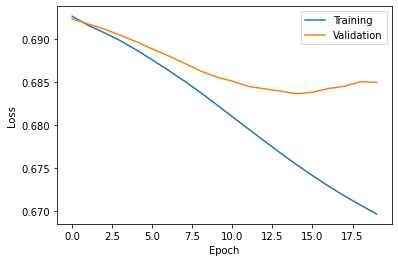

In [43]:
pic.plot_history(history)

In [44]:
y_b_pred = model.predict(X_p_test)

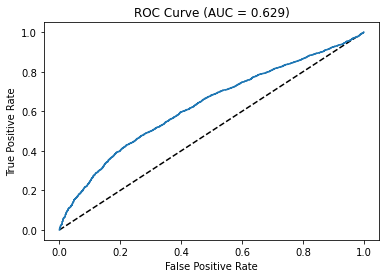

In [45]:
pic.plot_roc(y_b_test[:,0],y_b_pred[:,0])